#### Banking Customer Segmentation

In this project, I'm using unsupervised learning to create customer segments. The data is taken from UCI ML repository.  

In [26]:
#loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_score

In [27]:
#reading data
data = pd.read_csv('./german_credit_data.csv')
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [28]:
#droping column 1 as it is simply some id
data.drop(data.columns[0],inplace=True,axis=1)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [29]:
#checking data
print("Number of rows and colums.".format(data.shape[0],data.shape[1]))
print("Missing values in each column:\n{}".format(data.isnull().sum()))

Number of rows and colums.
Missing values in each column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


In [30]:
#number of unique values in columns
n_unique = data.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [31]:
#unique values in categorical column
print("Unique values in each categorical column:")
for column in data.select_dtypes(include=[object]):
    print(column,":",data[column].unique())

Unique values in each categorical column:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


#### Exploratory Data Analysis

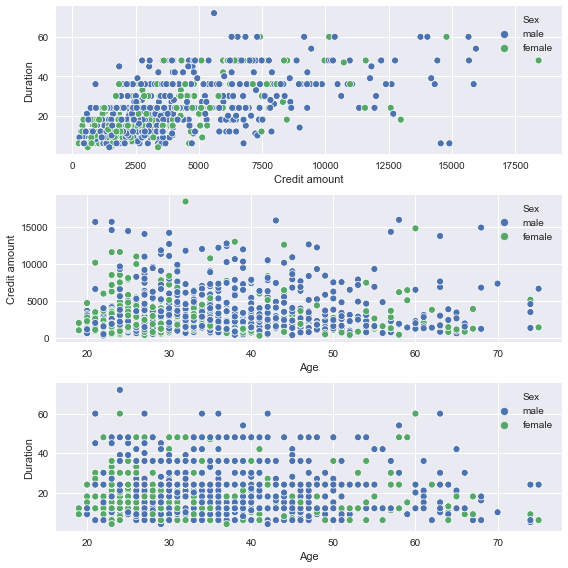

In [32]:
#plotting scatter plot between different numerical variables for different sexes

fig, (plt1, plt2, plt3) = plt.subplots(3,1, figsize=(8,8))
sns.scatterplot(x="Credit amount",y="Duration", hue="Sex", data=data, ax=plt1)
sns.scatterplot(x="Age",y="Credit amount", hue="Sex", data=data, ax=plt2)
sns.scatterplot(x="Age",y="Duration", hue="Sex", data=data, ax=plt3)    
plt.tight_layout()

It is clear from the first plot that there is a linear relationship between duration and credit amount. Generally, increase in duration results in increase in credit amount. Nothing significant coomes out from the last two graph.

Let's check how many credits are granted for various purpose.

Text(0,0.5,'Number of granted credits')

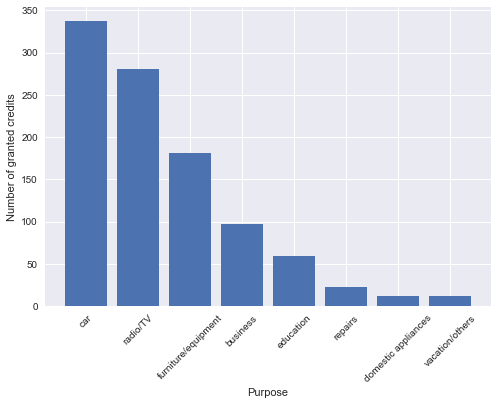

In [33]:
%matplotlib inline
plt.style.use('seaborn')  # prettier plots (for example, use 'ggplot' instead of 'seaborn' for plots like in R)

num_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
num_credits.sort_values(by=["Count"],ascending=False,inplace=True) 

plt.bar(num_credits['Purpose'], num_credits['Count'])
plt.xticks(rotation=45)
plt.xlabel('Purpose')
plt.ylabel('Number of granted credits')

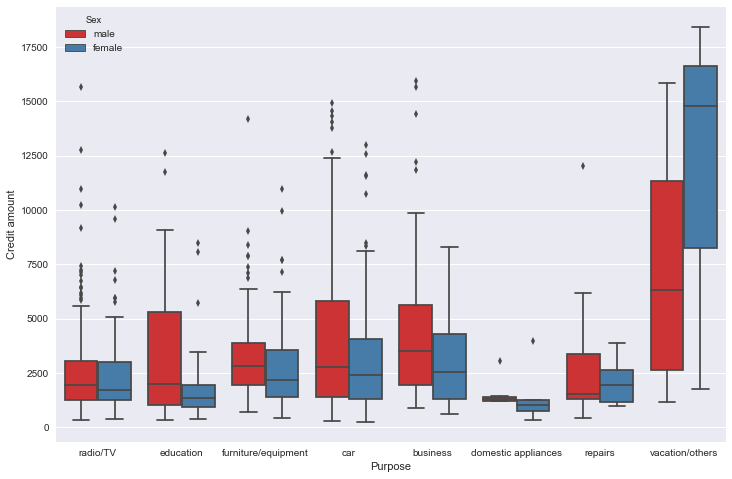

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x="Purpose", y="Credit amount", hue="Sex", data=data, palette="Set1")

As we can see from the above graph a lot of outliers lies on the upper side. There is no significant difference between credit amount of men and woman except for vacation/others but there was little number of credits granted in this category.

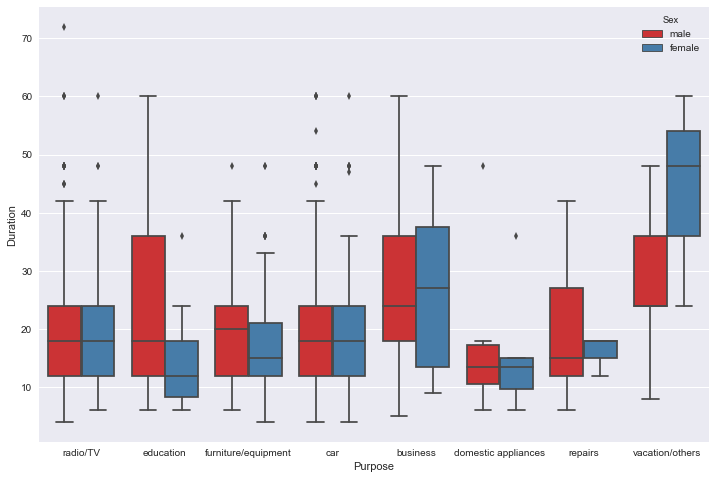

In [35]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x="Purpose", y="Duration", hue="Sex", data=data, palette="Set1")

There is no difference in credit duration between men and woman. This graph is in consent with the previous graph 

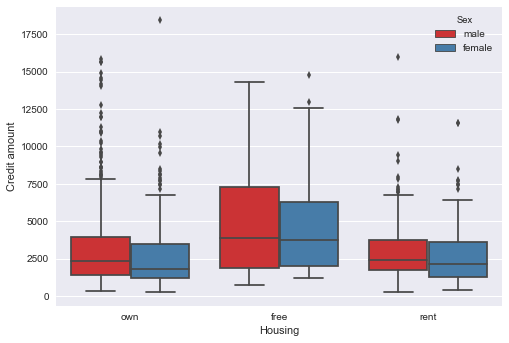

In [36]:
sns.boxplot(x="Housing", y="Credit amount", hue="Sex", data=data, palette="Set1")

People having "free" Housing category tend to have larger credit amount balance.

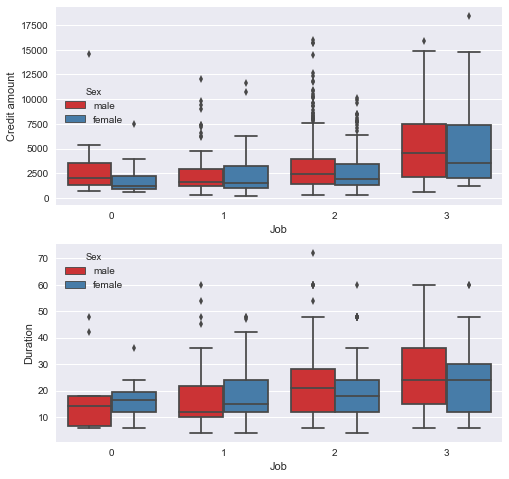

In [37]:
fig, (box1, box2) = plt.subplots(2,1, figsize=(8,8))
sns.boxplot(x="Job", y="Credit amount", hue="Sex", data=data, palette="Set1",ax=box1)
sns.boxplot(x="Job", y="Duration", hue="Sex", data=data, palette="Set1",ax=box2)

People who are in job category 3 tend to have higher credit amounts for longer duration. People who have job category two have higher duration as compared to job category 1 and 2.

###### Clustering with KMeans

For clustering I will create a subset containing only numerical variables (Age, Credit amount, Duration).

In [38]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
to_cluster = data.loc[:,selected_cols]

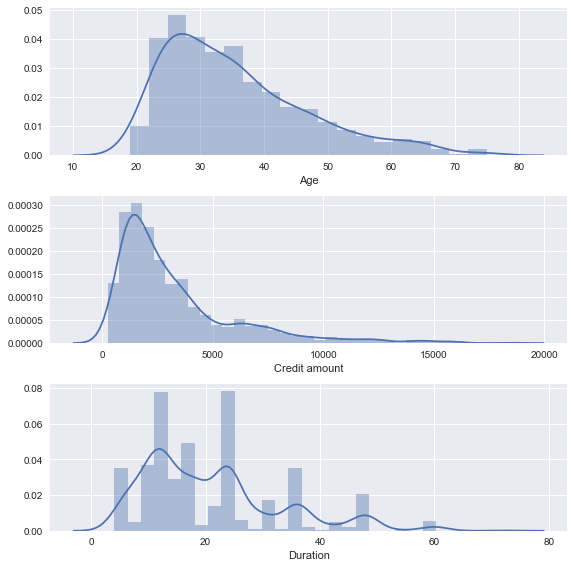

In [39]:
import warnings
warnings.filterwarnings("ignore")

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
sns.distplot(to_cluster["Age"], ax=ax1)
sns.distplot(to_cluster["Credit amount"], ax=ax2)
sns.distplot(to_cluster["Duration"], ax=ax3)
plt.tight_layout()

As we can see all three variables are right skewed. I will use logarithm transformation to obtain better results.

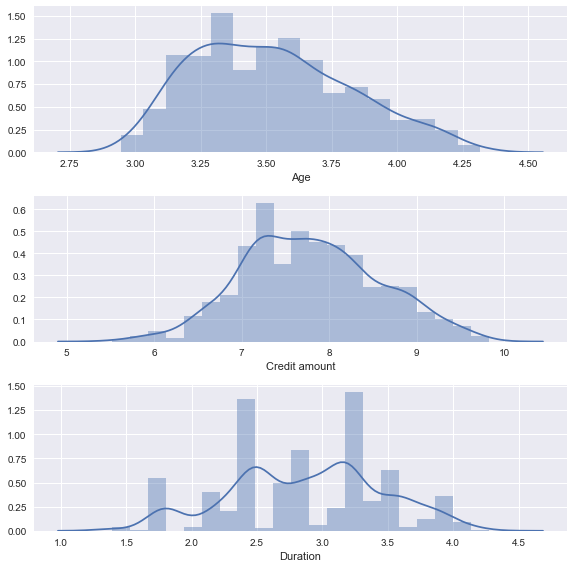

In [40]:
log_cluster = np.log(to_cluster)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
sns.distplot(log_cluster["Age"], ax=ax1)
sns.distplot(log_cluster["Credit amount"], ax=ax2)
sns.distplot(log_cluster["Duration"], ax=ax3)
plt.tight_layout()

As we can see from the above distributions, skewness has been removed. Scaling above variables which is required by K means allgorithm.

In [41]:
scaler = StandardScaler()
scaled_cluster = scaler.fit_transform(log_cluster)

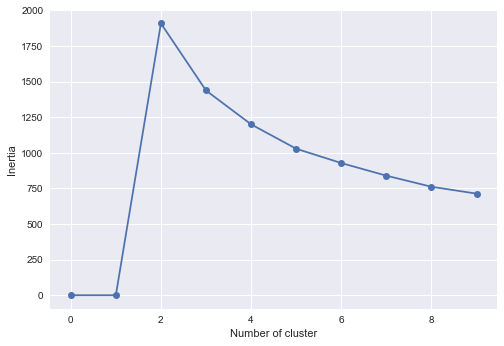

In [42]:
scores = []
inertia_list = np.empty(10)

for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_cluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(scaled_cluster, kmeans.labels_))

plt.plot(range(0,10),inertia_list,'-o')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.show()

We see that inertia deceases significantly until the number of clusters is 3/4 and then does not change as much anymore. This means that the optimal number of clusters is either 3 or 4. I will perform this analysis for various seeds.


###### Silhouette

Silhouette coefficient lets us estimate the quality of the clustering using only the initial, unlabeled sample and the clustering result. To start with, for each observation, the silhouette coefficient is computed. Let  a  be the mean of the distance between an object and other objects within one cluster and  b  be the mean distance from an object to an object from the nearest cluster (different from the one the object belongs to). Then the silhouette measure for this object is
$s=b−amax(a,b)$.
 
The silhouette of a sample is a mean value of silhouette values from this sample. Therefore, the silhouette distance shows to which extent the distance between the objects of the same class differ from the mean distance between the objects from different clusters. This coefficient takes values in the  [−1,1]  range. Values close to -1 correspond to bad clustering results while values closer to 1 correspond to dense, well-defined clusters. Therefore, the higher the silhouette value is, the better the results from clustering.

With the help of silhouette, we can identify the optimal number of clusters  k  (if we don't know it already from the data) by taking the number of clusters that maximizes the silhouette coefficient.

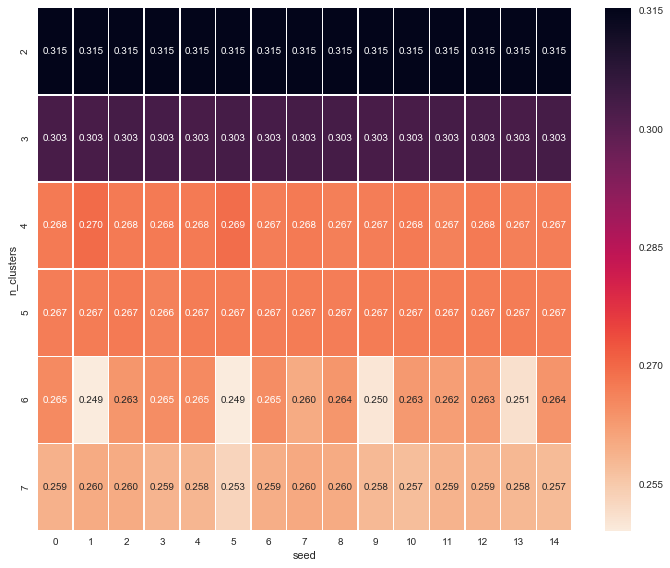

In [43]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,8)
random_range = range(0,15)
results =[]

for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(scaled_cluster)
        silhouette_avg = silhouette_score(scaled_cluster, cluster_labels)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(10,8))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

Heatmap shows silhouette score for different combination of clusters and seed. The highest score is for 2 clusters followed by 3. I'll choose 3 cluster as the previous methodology suggests cluster 3 and 4.

In [44]:
k_mean_cluster = KMeans(n_clusters=3,random_state=30).fit(scaled_cluster)
centers = k_mean_cluster.cluster_centers_

labels = pd.DataFrame(k_mean_cluster.labels_)
clustered_data = to_cluster.assign(Cluster=labels)

print(centers)

[[-0.09479942  0.93238099  0.92306198]
 [ 1.14348979 -0.5148609  -0.60141738]
 [-0.71206031 -0.59096693 -0.52016705]]


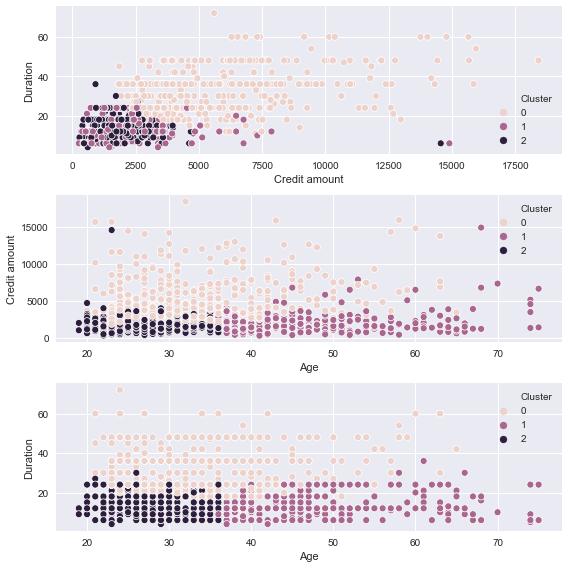

In [45]:
fig, (sp1, sp2, sp3) = plt.subplots(3,1, figsize=(8,8))
sns.scatterplot(x="Credit amount",y="Duration", hue='Cluster', data=clustered_data,ax=sp1)
sns.scatterplot(x="Age",y="Credit amount", hue='Cluster', data=clustered_data,ax=sp2)
sns.scatterplot(x="Age",y="Duration", hue='Cluster', data=clustered_data,ax=sp3)
plt.tight_layout()

Clustering is not evident from the first scatter plot but the bottom ones show clear separation among clusters.

In [46]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,34.0,5665.4,32.2
1,48.7,1979.7,13.9
2,27.8,1732.2,14.2


From the above pivot table we can figure out the characteristics of the 3 clusters:

Cluster 0 – high mean of credit amount, long duration, middle-aged customers

Cluster 1 – lower mean of credit amount, short duration, older customers

Cluster 2 - lower mean of credit amount, short duration, young customers

##### Clusturing with affinity propagation

As opposed to K-means, this approach does not require us to set the number of clusters beforehand. The main idea here is that we would like to cluster our data based on the similarity of the observations (or how they "correspond" to each other)

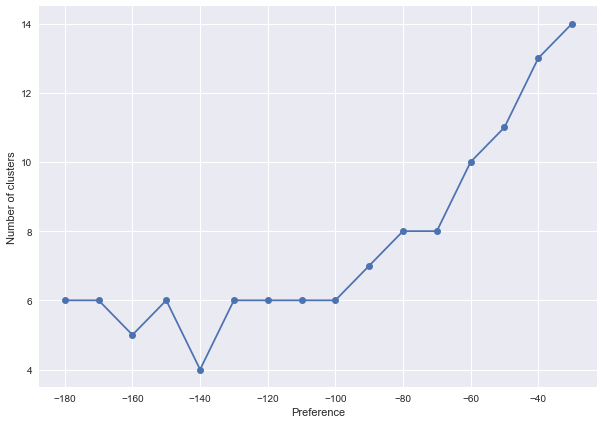

In [47]:
preferences = np.arange(-30,-190,-10)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(scaled_cluster)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')

Lowest value of Preference parameter is at cluster 4. I will check 4 clusters options.

In [48]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(scaled_cluster)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = to_cluster.assign(Cluster=labels_af)

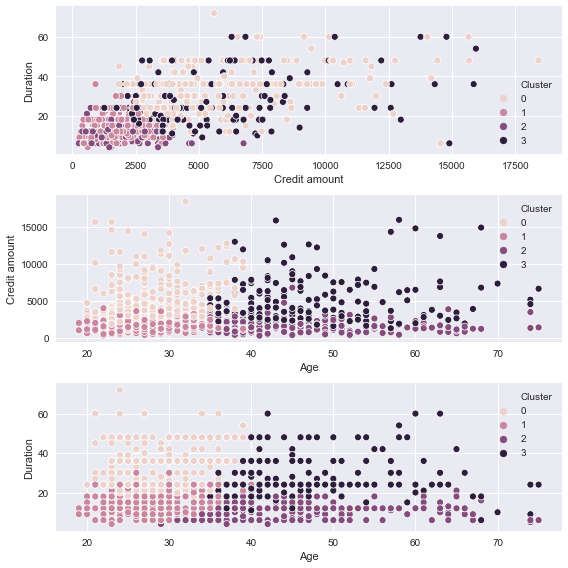

In [49]:
fig, (sp1, sp2, sp3) = plt.subplots(3,1, figsize=(8,8))
sns.scatterplot(x="Credit amount",y="Duration", hue='Cluster', data=clustered_data_af,ax=sp1)
sns.scatterplot(x="Age",y="Credit amount", hue='Cluster', data=clustered_data_af,ax=sp2)
sns.scatterplot(x="Age",y="Duration", hue='Cluster', data=clustered_data_af,ax=sp3)
plt.tight_layout()

In [50]:
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)
grouped_af

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6


Cluster 0 – high mean of credit amount, long duration, younger customers 

Cluster 1 – low mean of credit amount, short duration, younger customers 

Cluster 2 - low mean of credit amount, short duration, older customers 

Cluster 3 - high mean of credit amount, middle-time duration, older customers

#### Conclusion

I've tried two different mechanisms of clusturing - K means clusturing and affinity propagation. With the help of K means I divided the whole population in 3 segments and 4 segments with affinity propagation. 

Whether 3 segments are better or 4, depends on the problem we are solving. For example if the bank wants to run a marketing campaign where they want to target users who have low credit amounts then 3 clusters makes sense. But if the bank wants to run a marketing campaign to increase the use of credit amounts among young customers then 4 clusters makes sense, as the younger population is divided into two subgroups in 4 clusters. 